# 4. Фильтрация изображений
## 4.1 Операция свертки. Линейные фильтры
### Теория
- Сумма элементов ядра должна быть равной 1. Если больше 1 - изображение становится светлее. Если меньше 1 - темнее.
- Ядро \begin{vmatrix}
\ 0 & \ 0 & \ 0 \\
\ 0 & \ 0 & \ 1 \\
\ 0 & \ 0 & \ 0 
\end{vmatrix} сдвигает изображение на 1 пиксель влево.
- С помощью корреляции можно искать объекты (белый пик). *scipy.signal.correlate2d*
- Операция свертки *scipy.signal.convolve2d* При свертке ядро зеркалируется (отражение по вертикали и горизонтали).

In [1]:
import numpy as np
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage import img_as_ubyte
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
%matplotlib inline

### 4.1.1. Свертка
Выполните свертку изображения
\begin{bmatrix}
0 & -8 & -3 & -2\\
1 & 9 & -8 & 0\\
9 & -4 & 5 & -9\\
6 & -4 & 6 & 3
\end{bmatrix}
с ядром
\begin{bmatrix}
4 & -5 & 4 \\
-6 & -8 & -2\\
1 & 5 & 5
\end{bmatrix}
Результат выпишите построчно через пробел.

In [2]:
image = np.array([[0, -8, -3, -2], 
                [1, 9, -8, 0], 
                [9, -4, 5, -9], 
                [6, -4, 6, 3]])

kernel = np.array([[4, -5, 4], 
                   [-6, -8, -2], 
                   [1, 5, 5]])

print(convolve2d(kernel, image, mode='valid'))

[[  7 -88]
 [ 94  -7]]


### Теория
### Работа с краями изображения
- игнорирование. k - размер ядра -> уменьшение размера изображения на k/2 пикселя с каждой стороны
- заполнение константой (например, 0)-> черная граница
- взятие ближайшего значения
- зеркалирование границы (отражение границы изображения за её пределы)

### Box-фильтр
- в ядре записаны единицы, домножается на нормирующий коэффициент. Сумма всех элементов равна 1.
- дает размытое изображение

- Интегральное изображение *skimage.transform.integral_image*. Изображение того же размера, в каждом пикселе которого записана сумма пикселей от верхнего левого до данного пикселя.
- Сумма в произвольном прямоугольнике 
\begin{vmatrix}
\ B & \ - & \ D \\
\ | & \  & \ | \\
\ C & \ - & \ A 
\end{vmatrix}
- Sum = A + (B-1) - (C-1) - (D-1)
- *skimage.transform.integrate*
- Поделить на k*k

### 4.1.2. Box-фильтр.

Реализуйте box-фильтрацию изображения окном 5×5 пикселей. Дополнять изображение не нужно (т.е. изображение после фильтрации уменьшится). 

In [3]:
img = imread("https://stepik.org/media/attachments/lesson/61037/tiger-gray-small.png")
img2 = imread("https://stepik.org/media/attachments/lesson/61037/box-tiger.png")

In [4]:
def box_filter(img, size):
    res = np.zeros((img.shape[0]-size+1, img.shape[1]-size+1), dtype=np.int)

    for i in range (img.shape[0]-size+1):
        for j in range (img.shape[1]-size+1):

            a = 0
            for k in range (size):
                for n in range (size):
                    a = a + img[i + k, j + n]

            res [i, j] = int (a / size**2)
    return res

In [5]:
img = box_filter(img, 5)
np.array_equal(img2, img)

True

In [6]:
#встроенный способ
n = 5
img = imread("https://stepik.org/media/attachments/lesson/61037/tiger-gray-small.png")
res2 = convolve2d(rgb2gray(img), np.ones((n, n)), mode = "valid")
res2 = (res2/n/n).astype(np.uint8)
np.array_equal(img2, res2)

True

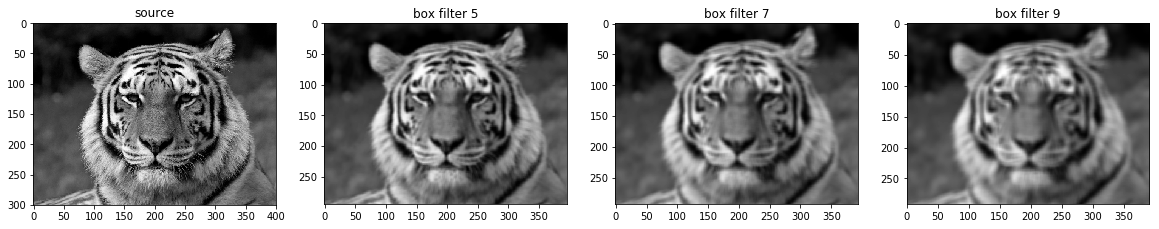

In [7]:
plt.figure(figsize=(20,10))
plt.set_cmap(cmap="gray")

plt.subplot(1,4,1)
plt.title("source")
plt.imshow(img)

plt.subplot(1,4,2)
plt.title("box filter 5")
plt.imshow(box_filter(img, 5))

plt.subplot(1,4,3)
plt.title("box filter 7")
plt.imshow(box_filter(img, 7))

plt.subplot(1,4,4)
plt.title("box filter 9")
plt.imshow(box_filter(img, 9))
plt.show()

### Теория
### Гауссовский фильтр
Box-фильтр дает паразитные вертикальные линии - артефакты. Гауссовский фильтр дает более качественный результат. Гауссовский фильтр в центральном пикселе принимает максимальное значение, ближе к краям значения становятся меньше.

Формула для функции Гаусса: \begin{equation*}G_{\sigma}(x, y) = \frac{1}{2\pi\sigma^2}e^{\frac{-x^2-y^2}{2\sigma^2}}\end{equation*}

Функция принимает максимальное значение в точке (0,0). Всюду положительна. Параметр 𝜎 - параметр разброса гауссианы. Чем меньше 𝜎, тем уже и выше функция Гаусса. При малом 𝜎 просматривается только небольшая область изображения, сглаживание небольшое.

`Половина ширины фильтра (радиус) равна 3𝜎`
### 4.1.3. Размер гауссовского фильтра
Какого размера (K) должен быть гауссовский фильтр для 𝜎=4?

`4*2*3+1 = 25`
### 4.1.4. Подсчет функции Гаусса
На вход подаются три числа: 𝜎, 𝑥, 𝑦. Подсчитайте значение функции Гаусса в этой точке. Формула для функции Гаусса: \begin{equation*}G_{\sigma}(x, y) = \frac{1}{2\pi\sigma^2}e^{\frac{-x^2-y^2}{2\sigma^2}}\end{equation*}

In [8]:
def gauss(sigma, x, y):
    return 1/((2*np.pi)*sigma**2)*np.e**((-x**2 - y**2)/(2*sigma**2))

In [9]:
sigma, x, y = [1, 1, 1]
gauss(sigma, x, y)

0.05854983152431917

### 4.1.5. Ядро гауссовского фильтра

На стандартный вход подается параметр 𝜎 гауссовского фильтра. Подсчитайте и напечатайте на стандартый вывод элементы ядра. Для подсчета значений функции Гаусса используйте функцию из предыдущего задания. 𝜎 может быть нецелым, тогда округлите 𝐾 с помощью функции round. Элементы ядра выводите с 5 цифрами после запятой.

In [10]:
def gauss_kernel(sigma):
    k = round(3*sigma)
    kernel = [[gauss(sigma, x, y) for x in range(-k, k+1)] for y in range(-k, k+1)]
    kernel = np.array(kernel)
    norm_kernel = kernel / np.sum(kernel, axis=(0,1))
    return norm_kernel

In [11]:
kernel = gauss_kernel(0.33)
#для stepic
print('\n'.join([' '.join(['{:.5f}'.format(item) for item in row]) for row in kernel]))

0.00010 0.00974 0.00010
0.00974 0.96065 0.00974
0.00010 0.00974 0.00010


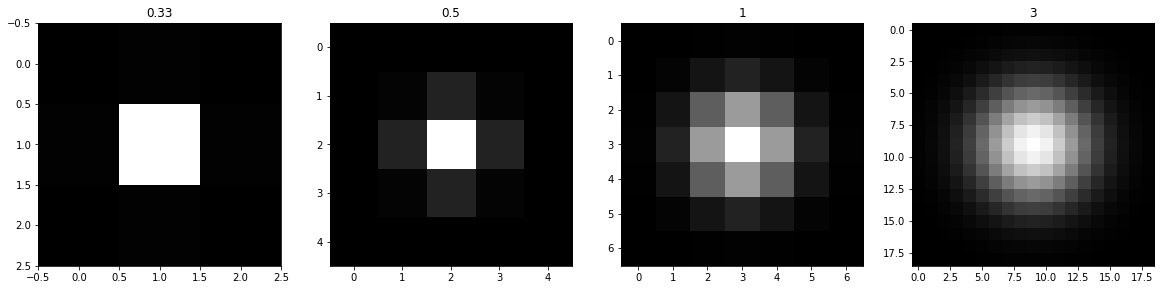

In [12]:
plt.figure(figsize=(20,10))

plt.subplot(1,4,1)
plt.title("0.33")
plt.imshow(gauss_kernel(0.33))

plt.subplot(1,4,2)
plt.title("0.5")
plt.imshow(gauss_kernel(0.5))

plt.subplot(1,4,3)
plt.title("1")
plt.imshow(gauss_kernel(1))

plt.subplot(1,4,4)
plt.title("3")
plt.imshow(gauss_kernel(3))
plt.show()

### 4.1.6. Гауссовская фильтрация.

Профильтруйте изображение гауссовским ядром с 𝜎=0.66. Для подсчета ядра используйте функцию из предыдущего задания. При подсчете новых значений изображения не забывайте обрезать их с помощью numpy.clip. Дополнять изображение не нужно (т.е. изображение после фильтрации уменьшится).

In [13]:
img = imread("https://stepik.org/media/attachments/lesson/61037/tiger-gray-small.png")
img2 = imread("https://stepik.org/media/attachments/lesson/61037/gaussian-tiger.png")

In [14]:
sigma = 0.66
kernel = gauss_kernel(sigma)
img = convolve2d(img, kernel, mode='valid').astype('uint8')

In [15]:
np.array_equal(img2, img)

True

In [16]:
img = imread("https://stepik.org/media/attachments/lesson/61037/tiger-gray-small.png")
img066 = convolve2d(img, gauss_kernel(0.66), mode='valid').astype('uint8')
img3 = convolve2d(img, gauss_kernel(3), mode='valid').astype('uint8')

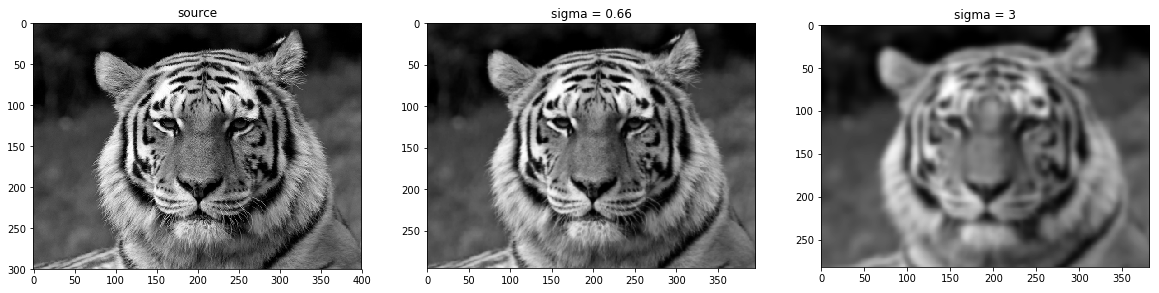

In [17]:
plt.figure(figsize=(20,10))
plt.set_cmap(cmap="gray")

plt.subplot(1,3,1)
plt.title("source")
plt.imshow(img)

plt.subplot(1,3,2)
plt.title("sigma = 0.66")
plt.imshow(img066)

plt.subplot(1,3,3)
plt.title("sigma = 3")
plt.imshow(img3)
plt.show()

## Повышение резкости изображения
Высокие частоты - резкие перепады на изображении. Вычесть из центрального пикселя все окружающие его.

### 4.1.7 Повышение резкости изображения.
Реализуйте повышение четкости изображения путём фильтрации изображения с ядром
\begin{equation*}\frac{1}{10}
\begin{bmatrix}
-1 & -2 & -1 \\
-2 & 22 & -2 \\
-1 & -2 & -1
\end{bmatrix}\end{equation*}
При подсчете новых значений изображения не забывайте обрезать их с помощью numpy.clip. Дополнять изображение не нужно (т.е. изображение после фильтрации уменьшится).

In [18]:
img = imread('https://stepik.org/media/attachments/lesson/61037/tiger-gray-small.png')
img2 = imread('https://stepik.org/media/attachments/lesson/61037/unsharp-tiger.png')

In [19]:
def sharpening(img):
    res = np.array([[[0] * img.shape[1]] * img.shape[0]], dtype='float')[0]

    kernel = np.array([[-1, -2, -1],
                       [-2, 22, -2],
                       [-1, -2, -1]]) / 10

    #stepic не принимает convolve2d
    for i in range(3, img.shape[0] + 1):
        for j in range(3, img.shape[1] + 1):
            res[i - 3, j - 3] = (img[i-3: i, j-3: j] * kernel).sum()


    res = np.clip(res[: - 2, : - 2], 0, 255).astype('uint8')
    return res

In [20]:
img = sharpening(img)
np.array_equal(img2, img)

True

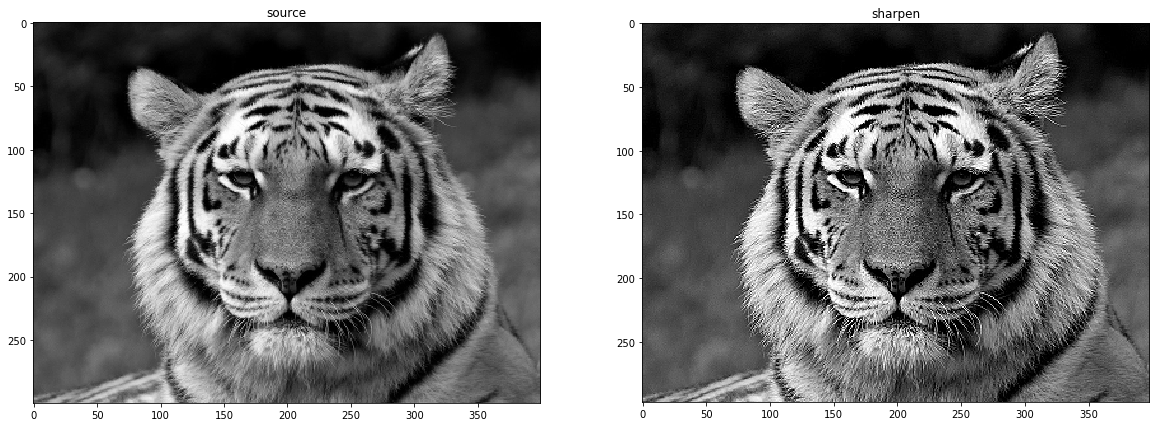

In [21]:
img = imread('https://stepik.org/media/attachments/lesson/61037/tiger-gray-small.png')

plt.figure(figsize=(20,10))
plt.set_cmap(cmap="gray")

plt.subplot(1,2,1)
plt.title("source")
plt.imshow(img)

plt.subplot(1,2,2)
plt.title("sharpen")
plt.imshow(img2)

plt.show()

## 4.2 Медианный фильтр
Шум - соль и перец. Выброс - outlier заменяется на медиану. Фильтр не имеет собственное ядро.
### 4.2.1. Медианный фильтр
Реализуйте медианную фильтрацию изображения окном 7×7 пикселей. Дополнять изображение не нужно (т.е. изображение после фильтрации уменьшится). 

In [22]:
img = imread('https://stepik.org/media/attachments/lesson/61041/tiger-gray-small.png')
img2 = imread('https://stepik.org/media/attachments/lesson/61041/median-tiger.png')

In [23]:
def median_filter(img, size):
    res = img.copy()
    rows,cols = img.shape
    half = size//2 #для 7 будет 3

    for i in range(half,rows-half):
        for j in range(half,cols-half):
            # 7х7
            a = img[i-half:i+half+1,j-half:j+half+1]
            m = np.median(a)
            res[i][j] = m

    res = res[half:rows-half,half:cols-half]
    return res

In [24]:
img = median_filter(img, 7)

In [25]:
np.array_equal(img2, img)

True

In [26]:
#встроенный способ
from scipy.ndimage.filters import median_filter

img = imread('https://stepik.org/media/attachments/lesson/61041/tiger-gray-small.png')
res = median_filter(img ,size=7)[3:-3,3:-3]
np.array_equal(img2, res)

True

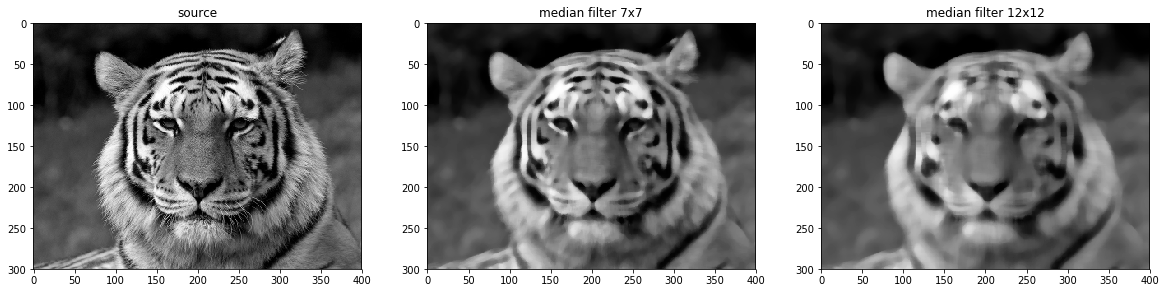

In [27]:
plt.figure(figsize=(20,10))
plt.set_cmap(cmap="gray")

plt.subplot(1,3,1)
plt.title("source")
plt.imshow(img)

plt.subplot(1,3,2)
plt.title("median filter 7x7")
plt.imshow(median_filter(img ,size=7))

plt.subplot(1,3,3)
plt.title("median filter 12x12")
plt.imshow(median_filter(img ,size=12))
plt.show()

### 4.2.2. Медианный фильтр
Предположим, что мы хотим профильтровать изображение размером 600 строк и 800 столбцов с помощью алгоритма быстрой медианной фильтрации окном размера 7x7 пикселей. Будем накладывать окно так, чтобы оно не выходило за границы изображения (т.е. в результате фильтрации изображение уменьшится).

Сколько раз алгоритму потребуется инициализировать гистограмму H?

`594`

### 4.2.3. Медианный фильтр
Сколько раз алгоритму потребуется обновить гистограмму H (т.е. сдвинуть окно на 1 пиксель вправо)?

`471042`